In [1]:
from torchvision.utils import draw_bounding_boxes
from torch.utils.data import DataLoader
import torchvision
from torch import nn
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np

In [2]:
torch.manual_seed(256)
np.random.seed(0)

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device.")

Using cpu device.


1. Load the 3 localization datasets `localization XXX.pt`. There is at most one digit per image. All digits are represented ($C$ = 10).

In [4]:
train_dataset = torch.load('data/localization_train.pt')
val_dataset = torch.load('data/localization_val.pt')
test_dataset = torch.load('data/localization_test.pt')

In [5]:
print(f"Training Set: {len(train_dataset)} images")
print(f"Validation Set: {len(val_dataset)} images")
print(f"Test Set: {len(test_dataset)} images")

Training Set: 59400 images
Validation Set: 6600 images
Test Set: 11000 images


In [6]:
sample_image, sample_label = train_dataset[0]
print(f"Sample Image Shape: {sample_image.shape}")
print(f"Sample Label: {sample_label}")

Sample Image Shape: torch.Size([1, 48, 60])
Sample Label: tensor([1.0000, 0.6000, 0.2292, 0.3667, 0.4167, 4.0000])


In [7]:
batch_size = 256
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [8]:
def get_bbox(x, y, w, h, img_width, img_height):
    # convert bounding box format from [center_x, center_y, width, height] to [x_min, y_min, x_max, y_max]
    x_min = (x - w / 2) * img_width
    y_min = (y - h / 2) * img_height
    x_max = (x + w / 2) * img_width
    y_max = (y + h / 2) * img_height
    return [x_min, y_min, x_max, y_max]

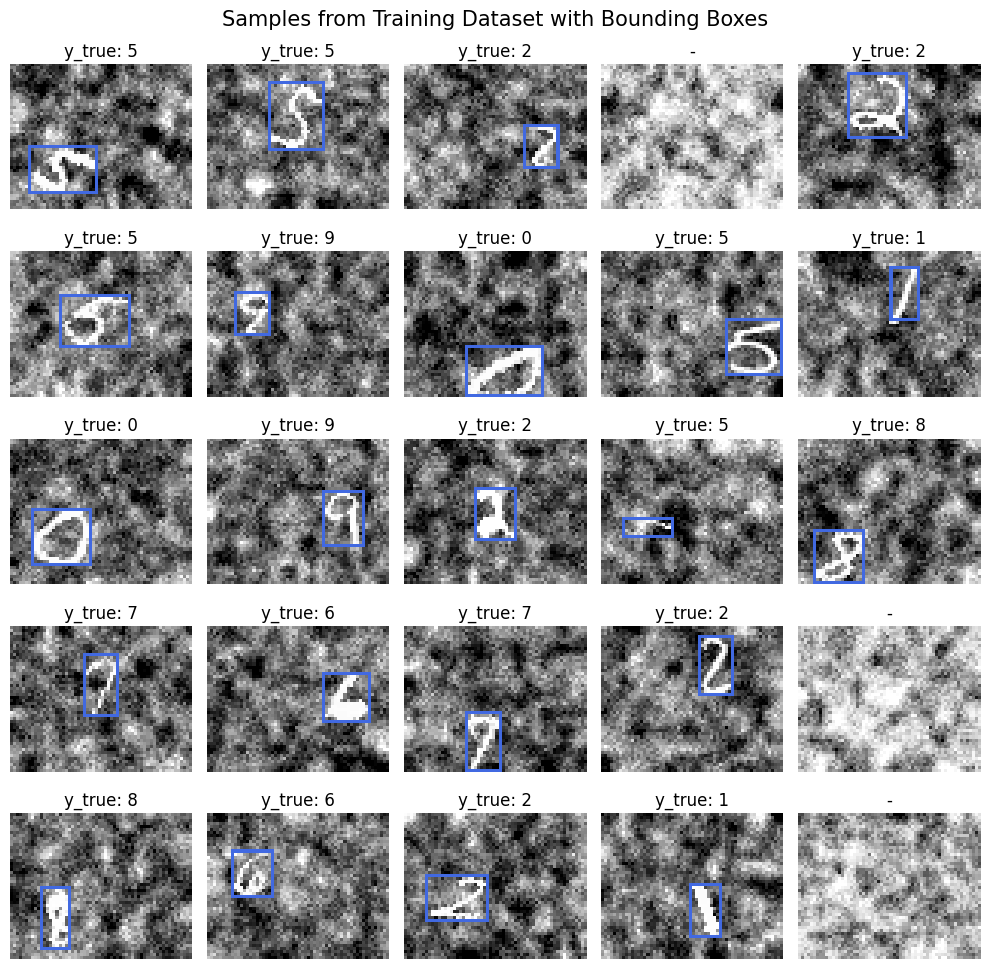

In [9]:
img_height, img_width = 48, 60
sample_indices = np.random.choice(len(train_dataset), 25, replace=False)

# image, bounding box, binary p_c, label
samples = [(train_dataset[idx], get_bbox(*train_dataset[idx][1][1:5], img_width, img_height),
            train_dataset[idx][1][0], train_dataset[idx][1][5]) for idx in sample_indices]

fig, axs = plt.subplots(5, 5, figsize=(10, 10))

for ax, ((image, _), bbox, p_c, label) in zip(axs.ravel(), samples):
    img = (image * 255).to(torch.uint8)
    if p_c:
        img = draw_bounding_boxes(img, torch.tensor([bbox], dtype=torch.float), colors="royalblue", width=1)

    ax.imshow(torchvision.transforms.functional.to_pil_image(img), cmap="Greys")
    ax.set_title(f"y_true: {int(label)}" if p_c else "-")
    ax.axis('off')

fig.suptitle("Samples from Training Dataset with Bounding Boxes", fontsize=15)
plt.tight_layout()
plt.show()

2. Implement and train several convolutional models suitable for an object localization task and the data provided.

In [10]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()

        # Convolutional Layers
        self.conv1 = nn.Conv2d(1, 96, kernel_size=3, stride=1, padding=1)
        # Conv1: Input 48x60x1 -> Output 48x60x96
        # Output: (W - K + 2P)/S + 1 = (48-3+2*1)/1 + 1 = 48; (60-3+2*1)/1 + 1 = 60

        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2)
        # Conv2: Input 24x30x96 (after pooling) -> Output 24x30x256
        # Output size before pooling: (48-5+2*2)/1 + 1 = 48; (60-5+2*2)/1 + 1 = 60
        # After pooling: (24-2)/2 + 1 = 12; (30-2)/2 + 1 = 15

        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        # Conv3: Input 12x15x256 -> Output 12x15x384
        # Output: (12-3+2*1)/1 + 1 = 12; (15-3+2*1)/1 + 1 = 15

        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1)
        # Conv4: Input 12x15x384 -> Output 12x15x384
        # Dimensions remain unchanged (same as Conv3)

        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1)
        # Conv5: Input 12x15x384 -> Output 12x15x256
        # Before final pooling, size is the same as input
        # After pooling: (12-2)/2 + 1 = 6; (15-2)/2 + 1 = 7

        # Max-pooling Layer
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # Pooling: Halves the dimensions each time it's applied

        # Fully Connected Layers
        # Calculating size after final pooling layer (6x7x256) for the FC layer's input
        self.fc1 = nn.Linear(6 * 7 * 256, 1024)
        # FC1: Flattened inputs from 6x7x256 to 1024 outputs

        self.fc2 = nn.Linear(1024, 1024)
        # FC2: Maintains the size to 1024 outputs

        self.fc3 = nn.Linear(1024, num_classes + 5)
        # FC3: Final layer for classification + localization, outputting num_classes + 5

        # Dropout Layer
        self.dropout = nn.Dropout(0.5)
        # Dropout applied after the first and second FC layers to prevent overfitting

    def forward(self, x):
        # Convolutional and pooling layers sequence
        x = self.pool(F.relu(self.conv1(x)))  # After Conv1 and Pool: 24x30x96
        x = self.pool(F.relu(self.conv2(x)))  # After Conv2 and Pool: 12x15x256
        x = F.relu(self.conv3(x))  # After Conv3: 12x15x384
        x = F.relu(self.conv4(x))  # After Conv4: 12x15x384
        x = self.pool(F.relu(self.conv5(x)))  # After Conv5 and Pool: 6x7x256

        # Flatten for the fully connected layers
        x = x.view(-1, 6 * 7 * 256)  # Flatten the output to match FC layer input

        # Fully connected layers with ReLU activations and dropout
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x)  # Output layer without ReLU (classification layer)

        return x

In [11]:
def loss_fn(y_pred, y_true):
    # Detection Loss L_A
    detection_loss_fn = nn.BCEWithLogitsLoss()
    detection_loss = detection_loss_fn(y_pred[:, 0], y_true[:, 0])

    # Localization Loss L_B applied conditionally
    localization_loss_fn = nn.MSELoss(reduction='none')
    # calculate element-wise localization loss only for instances where an object is present
    localization_loss = localization_loss_fn(y_pred[:, 1:5], y_true[:, 1:5])
    object_presence = y_true[:, 0].unsqueeze(1)  # Ensure it's compatible for element-wise multiplication
    # use torch.where to apply loss only where object is present, else zero loss
    localization_loss = torch.where(object_presence == 1, localization_loss, torch.zeros_like(localization_loss))
    # sum and normalize the localization loss by the number of objects in the batch
    localization_loss = localization_loss.sum() / (object_presence.sum() + 1e-6)

    # Classification Loss L_C applied conditionally
    classification_loss_fn = nn.CrossEntropyLoss(reduction='none')
    # classification loss computed for all, but scaled down to 0 where no object is present
    classification_loss = classification_loss_fn(y_pred[:, 5:], y_true[:, -1].long())
    # apply loss only where object is present
    classification_loss = torch.where(y_true[:, 0] == 1, classification_loss, torch.zeros_like(classification_loss))
    # average the classification loss only over instances with objects
    classification_loss = classification_loss.sum() / (object_presence.sum() + 1e-6)

    # combine all three components of the loss
    total_loss = detection_loss + localization_loss + classification_loss

    return total_loss

In [12]:
def train_model(model, optimizer, train_loader, epochs=10):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            print(i, loss.item())
        print(f"Epoch {epoch + 1}, Loss: {total_loss / len(train_loader)}")

In [ ]:
model = AlexNet().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
train_model(model, optimizer, train_loader, epochs=1)